### Настройка среды

In [1]:
import os
import sys

### Yandex Datasphere
# sys.path.append(os.path.abspath(".."))

### Google Colab
!git clone https://github.com/Belashov641618/OpticalEncoder.git
sys.path.append(os.path.abspath("OpticalEncoder"))

Cloning into 'OpticalEncoder'...
remote: Enumerating objects: 435, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 435 (delta 31), reused 35 (delta 17), pack-reused 386
Receiving objects: 100% (435/435), 20.74 MiB | 24.75 MiB/s, done.
Resolving deltas: 100% (245/245), done.


In [2]:
%cd OpticalEncoder
!dir
!git pull

/content/OpticalEncoder
elements  main.py  notebooks  parameters.py  tests  utilities
Already up to date.


In [3]:
%pip install belashovplot
%pip install optuna
%pip install timm

  Preparing metadata (setup.py) ... done
  Created wheel for belashovplot: filename=belashovplot-1.0-py3-none-any.whl size=12758 sha256=e8ebd1943118df7ae49ce80ae727195ba82ab19511ded0e805da38e4413baaf1
  Stored in directory: /root/.cache/pip/wheels/55/7b/e2/e5bf08c4c48d0989afbcb220497fa4bb6805a32f6c7826eece
Successfully built belashovplot
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl

In [4]:
from belashovplot import TiledPlot
from utilities import *
from utilities.filters import Gaussian, Window
from utilities.training import train, confusion
from elements.modulators import Lens, PhaseModulator
from elements.propagators import FurrierPropagation, ConvolutionalPropagation
from elements.composition import CompositeModel, HybridModel
from elements.wrappers import CudaMemoryChunker, Incoherent
from elements.detectors import ClassificationDetectors, MatrixDetectors
from parameters import FigureWidthHeight, FontLibrary
from tqdm import tqdm
from math import sin, sqrt
from pickle import dump
import torch
import numpy
import optuna
import timm

## Оптимизация ResNet14

In [33]:
resnet = timm.create_model('resnet18', pretrained=True,  in_chans=1, num_classes=10)
resnet = resnet.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

dataset = Dataset('CIFAR10', 50, 32, 32)
optimizer = torch.optim.Adam(resnet.parameters(), lr=0.001)
loss_function = torch.nn.CrossEntropyLoss()

confusions = [confusion(resnet, dataset, 10)]
print(f'Accuracy: {100 * numpy.sum(numpy.diagonal(confusions[-1], 0)) / numpy.sum(confusions[-1])}')
for i in range(10):
  train(resnet, dataset, optimizer, loss_function)
  confusions.append(confusion(resnet, dataset, 10))
  print(f'Accuracy: {100 * numpy.sum(numpy.diagonal(confusions[-1], 0)) / numpy.sum(confusions[-1])}')

ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 512, 1, 1])

## Оптимизация с помощью optuna

### Создание функции минимизации для optuna

In [5]:
# Не изменяемые параметры системы
# Когерентность
spatial_coherence = 50.0E-6
time_coherence = 10.0E-9
time_relaxation = 1.0E-6

# Оптика
wavelength = 500.0E-9


# Детекторы

# Электроника

In [6]:
def objective(trial:optuna.trial):
  mean_samples      = trial.suggest_int('mean_samples', 1, 30)
  mask_unit_length  = trial.suggest_categorical('mask_unit_length', [7.0E-6, 14.0E-6, 21.0E-6, 28.0E-6, 35.0E-6, 42.0E-6, 49.0E-6])
  mask_units        = trial.suggest_int('mask_units', 10, 250)

  length = mask_unit_length * mask_units


## Настройка некогерентности

In [7]:
spatial_coherence = 50.0E-6
time_coherence = 10.0E-9
time_relaxation = 1.0E-6
mean_samples = 20 #100

print(f"Временная когерентность:        {engineering(time_coherence, 'с')}")
print(f"Время релаксации:               {engineering(time_relaxation, 'c')}")
print(f"Пространственная когерентность: {engineering(spatial_coherence, 'м')}")

Временная когерентность:        10.0 нс
Время релаксации:               1.0 мкc
Пространственная когерентность: 50.0 мкм


## Система без линз

Описание системы

### Настройка параметров системы

In [40]:
length = 5.0E-3
wavelength = 500E-9
mask_unit_length = 30.0E-6
masks_amount = 5
cppp = 2

pixels = int(length/mask_unit_length) + 1
N = int(pixels*cppp)
distance = length * sqrt((mask_unit_length/wavelength)**2-1) * 0.5

print(f"Длинна волны:                             {engineering(wavelength, 'м')}")
print(f"Количество вычислительных пикселей:       {N}")
print(f"Количество пикселей маски:                {pixels}")
print(f"Количество модуляторов:                   {masks_amount}")
print(f"Размер оптических элементов:              {engineering(length, 'м')}")
print(f"Размер пикселя маски:                     {engineering(mask_unit_length, 'м')}")
print(f"Расстояние между слоями:                  {engineering(distance, 'м')}")

Длинна волны:                             500.0 нм
Количество вычислительных пикселей:       334
Количество пикселей маски:                167
Количество модуляторов:                   5
Размер оптических элементов:              5.0 мм
Размер пикселя маски:                     30.0 мкм
Расстояние между слоями:                  149.979 мм


### Отрисовка некогерентности

0.000571443815715611 0.48211465664062503
0.00045290167327038944 0.2975162139490659
8.621831511845812e-05 0.36719853397266594
0.00011759973858715966 0.22660069776022107
3.921348979929462e-05 0.03495920563046241
4.231764978612773e-05 0.04314712427253604
3.2847136026248336e-05 0.006656595521178909
3.2319043384632096e-05 0.008215660196067051
2.9778233511024155e-05 0.010139878897927466
4.2518440750427544e-05 0.00625738781856233
7.586307765450329e-05 0.0019307381629525805
3.0543491448042914e-05 4.654185832474172e-06
2.9998192985658534e-05 5.7442590836862645e-06
2.862703513528686e-05 8.862052786515823e-07
0.00011729204561561346 8.45151213313658e-13
Parameter containing:
tensor([0.1374, 0.4535, 1.0066, 1.0078], device='cuda:0')


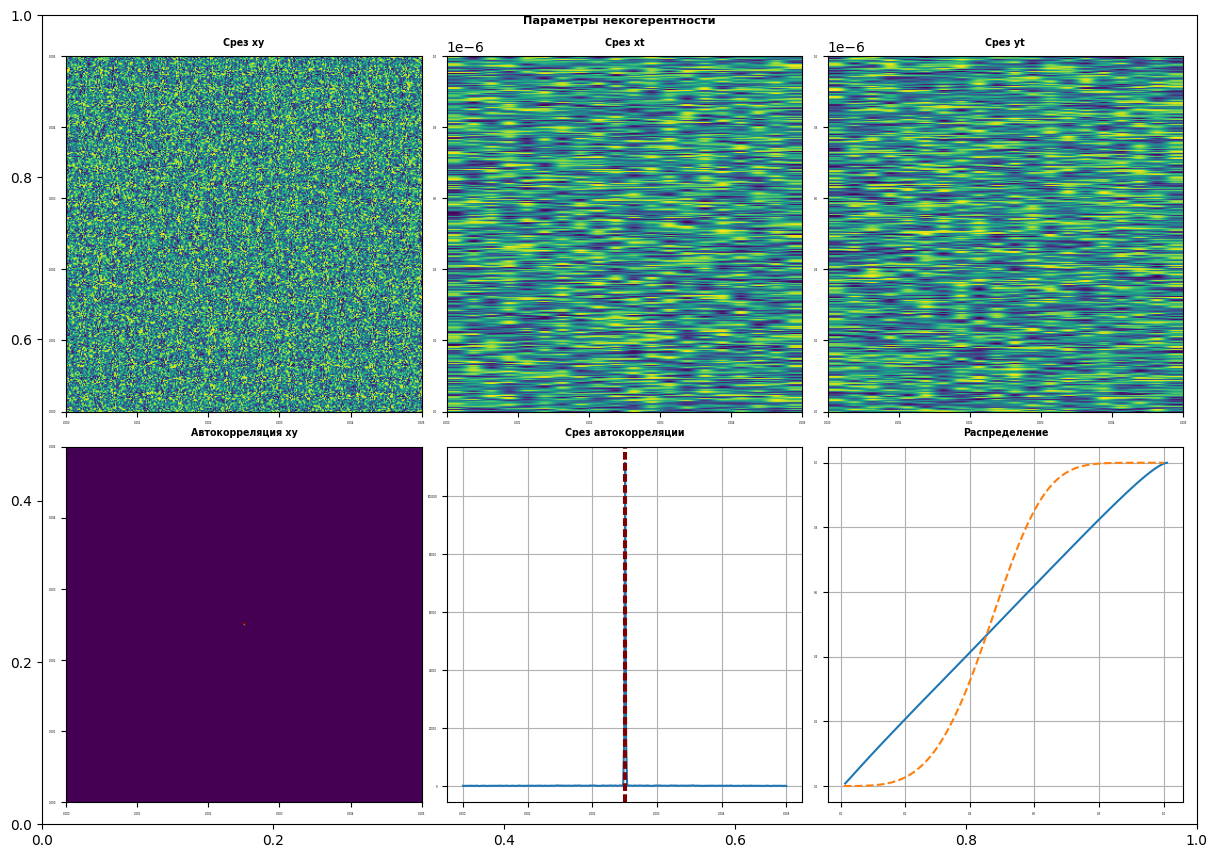

In [41]:
incoherent = Incoherent(spatial_coherence, time_coherence, time_relaxation, mean_samples, N, length)
incoherent = incoherent.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
incoherent.delayed.launch()
incoherent.show()

### Инициализация оптической модели

In [42]:
propagation = FurrierPropagation(N, length, wavelength, 1.0, 0.0, distance, 0.3)
modulators = [PhaseModulator(N, length, pixels) for i in range(masks_amount)]
elements = [modulators[0]]
for modulator in modulators[1:]:
    elements.append(propagation)
    elements.append(modulator)
elements.append(propagation)

chunker = CudaMemoryChunker()

optical = CompositeModel(*elements)
optical.wrap(chunker)
optical.wrap(incoherent)
optical.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

CompositeModel(
  (Element0): PhaseModulator()
  (Element1): FurrierPropagation()
  (Element2): PhaseModulator()
  (Element3): FurrierPropagation()
  (Element4): PhaseModulator()
  (Element5): FurrierPropagation()
  (Element6): PhaseModulator()
  (Element7): FurrierPropagation()
  (Element8): PhaseModulator()
  (Element9): FurrierPropagation()
  (Wrapper0): CudaMemoryChunker()
  (Wrapper1): Incoherent(
    (_generator): GaussianNormalizer(
      (_generator): FourierMask()
    )
  )
)

### Инициализация детекторов

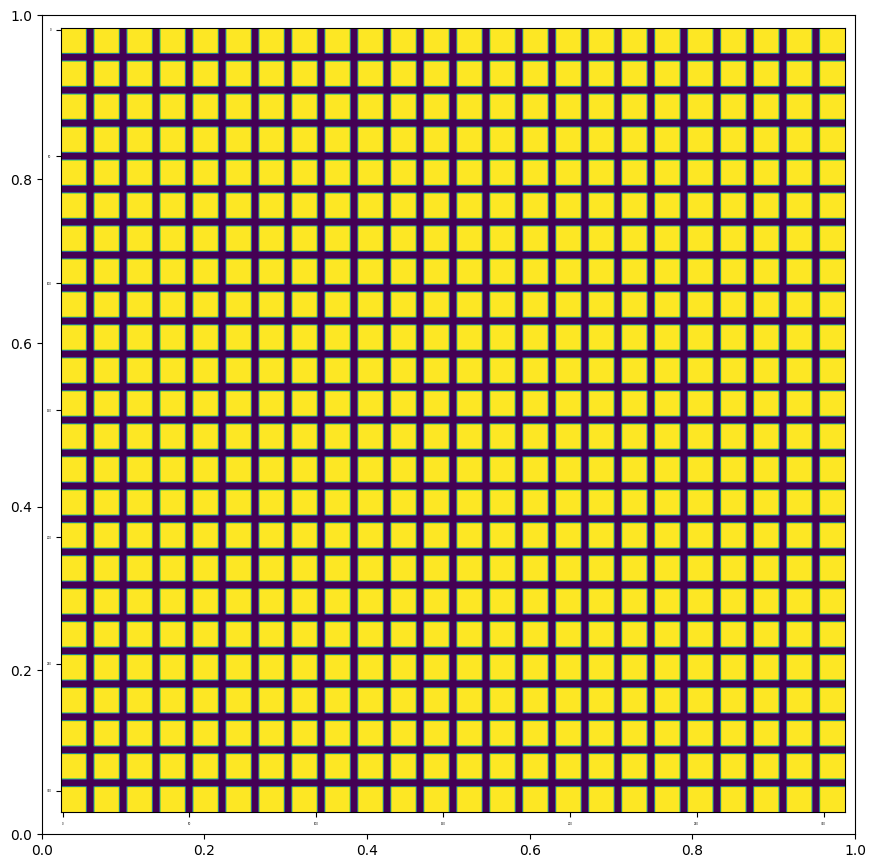

In [43]:
detectors_amount = 24

spectral_filter = Window(centers=wavelength, sizes=300.0E-9)
# detectors_filter = Gaussian((length/100, length/100), (0,0))
detectors_filter = Window(centers=(0.,0.), sizes=(length/34, length/34))
detectors = MatrixDetectors(N, length, wavelength, detectors_amount, detectors_filter, spectral_filter)
detectors.to(optical.device)

plot = TiledPlot(*FigureWidthHeight)
plot.FontLibrary = FontLibrary
plot.axes.add(0,0).imshow(detectors.filter, aspect='auto')
plot.show()

### Инициализация электронной модели

In [44]:
electronic = timm.create_model('resnet18', pretrained=True,  in_chans=1, num_classes=10)
electronic.to(optical.device)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

### Инициализация гибридной модели

In [45]:
model = HybridModel(optical, detectors, electronic)

In [46]:
dataset = Dataset('CIFAR10', 30, N, N, torch.complex64)
dataset.train
dataset.test

Files already downloaded and verified
Files already downloaded and verified


In [47]:
# dsi = iter(dataset.train)
# with torch.no_grad():
    # model.visualize(next(dsi)[0][:1, :1].to(model.device))
    # model.visualize(next(dsi)[0][:1, :1].to(model.device))


### Инициализация лосс функции и обучающего модуля

In [48]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

### Обучение модели

In [49]:
history = []
confusions = []

In [ ]:
confusions.append(confusion(model, dataset))
print(f'Accuracy: {100 * numpy.sum(numpy.diagonal(confusions[-1], 0)) / numpy.sum(confusions[-1])}')
for i in range(10):
  history.append(train(model, dataset, optimizer, loss_function))
  confusions.append(confusion(model, dataset))
  print(f'Accuracy: {100 * numpy.sum(numpy.diagonal(confusions[-1], 0)) / numpy.sum(confusions[-1])}')

100%|██████████| 334/334 [05:49<00:00,  1.05s/it]


Accuracy: 10.0


RLoss: 2.320268172011794, RPI1000: -0.003105593271448958:  78%|███████▊  | 1304/1667 [46:20<12:53,  2.13s/it] 

In [ ]:
# plot = TiledPlot(*FigureWidthHeight)
# plot.FontLibrary = FontLibrary
# plot.axes.add(0,0).plot(history)
# plot.axes.add(0,0).imshow(image.cpu().abs()[0][0]**2)
# plot.show()

In [ ]:
# dsi = iter(dataset.train)
# with torch.no_grad():
    # model.visualize(next(dsi)[0][:1, :1].to(model.device))
    # model.visualize(next(dsi)[0][:1, :1].to(model.device))

In [ ]:
print(confusions[0], '\n', confusions[-1])